In [19]:
import cvxpy as cp
from scipy.special import roots_sh_legendre
from scipy.sparse import csr_array
import numpy as np
import matplotlib.pyplot as plt

In [20]:
class Word:
    def __init__(self, word: str):
        self._word = word
    def __repr__(self):
        return repr(self._word)
    def __hash__(self):
        return hash(self._word)
    def __eq__(self, other):
        if not isinstance(other, Word):
            return False
        return self._word == other._word

class SiteBasis:
    def __init__(self, N):
        self._N = N
        self._ops = 'IXYZ'
    
    def rank(self, word: Word|str):
        if isinstance(word, Word):
            word = word._word
        if len(word) != self._N:
            raise ValueError(f'{word} must be of length {self._N}')
        r = 0
        for i, op in enumerate(reversed(word)):
            if op not in self._ops:
                raise ValueError(f'{word} must have only IXYZ')
            r += (4 ** i) * (self._ops.find(op))
        return r

    def unrank(self, pos: int):
        word = [None] * self._N
        for i in range(self._N):
            word[i] = self._ops[pos % 4]
            pos //= 4
        return ''.join(word[::-1])

def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2j, 'Z'),(-2j, 'Y')],
        [(0, ''),(-2j, 'Z'),(0, ''),(2j, 'X')],
        [(0, ''),(2j, 'Y'),(-2j, 'X'),(0, '')],
    ]
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_anticommutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_commutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    return (coeff, ''.join(word))

<h2>Thermal Transverse Field Ising:</h2>

In [21]:
def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for c, op in terms:
            if len(op) != len(word1):
                continue
            expression.append((op, coeff * c))
    return expression

def translation_symmetry(word1):
    return [(word1, 1), (word1[1:] + word1[0], -1)]

def normalization(B):
    return [B[0] == 1]

def thermal_density_matrix(basis: SiteBasis, B, L, nm):
    n = nm
    def get_term(i, j):
        coeff, word = product(basis.unrank(i), basis.unrank(j))
        return coeff * B[basis.rank(word)]
    
    M = cp.bmat([[get_term(i, j) for j in range(n)] for i in range(n)])
    return [M >> 0]

In [22]:
def gen_basis(L):
    basis = SiteBasis(L)
    exclude = set()
    for i in range(4 ** L):
        if i in exclude:
            continue
        op = basis.unrank(i)
        if 2 * op.count('I') > L:
            exclude.add(i)
            continue
        op2 = op
        for j in range(L - 1):
            op = op[1:] + op[0]
            if op == op2:
                break
            exclude.add(basis.rank(op))
    small_basis = []
    for i in range(4 ** L):
        if i in exclude:
            continue
        small_basis.append(basis.unrank(i))
    return small_basis

def beta_independent_constraints(basis, B, L, hamil, nm):
    constraints = []
    if nm > 0:    
        constraints.extend(thermal_density_matrix(basis, B, L, nm))
    constraints.extend(normalization(B))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = 4 ** L
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        for term in terms:
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for i in range(n):
        add_terms(schwinger_dyson(hamil, basis.unrank(i)))
        add_terms(translation_symmetry(basis.unrank(i)))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def beta_independent_kms_constraints(basis, H, n, L, m, k, hamil):
    # ops = ['IX','IY','IZ','XY','XZ','YZ']
    ops = gen_basis(L)
    n = len(ops)
    # print(ops)
    constraints = []
    def get_A_term(i, j):
        # coeff, word = product(basis.unrank(i), basis.unrank(j))
        coeff, word = product(ops[i], ops[j])
        return coeff * H[basis.rank(word)]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    Ts = [cp.Variable((n,n),f'T_{i}',hermitian=True) for i in range(1, m + 1)]
    Zs = [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(0, k + 1)]
    constraints.append(Zs[0] == cp.transpose(A))
    ts, _ = roots_sh_legendre(m)
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    for j in range(m):
        constraints.append(cp.bmat([[Zs[k] - A - Ts[j], -np.sqrt(ts[j]) * Ts[j]],
                                    [-np.sqrt(ts[j]) * Ts[j], A - ts[j] * Ts[j]]]) >> 0)
    def get_C_term(i, j):
        expression = 0
        for coeff, w in hamil:
            # terms = commutator(w, basis.unrank(j))
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                # c2, op2 = product(basis.unrank(i), op)
                c2, op2 = product(ops[i], op)
                expression = expression + coeff * c * c2 * H[basis.rank(op2)]
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    return Ts, C, constraints

def beta_dependent_kms_constraints(Ts, C, m, k, beta):
    constraints = []
    _, ws = roots_sh_legendre(m)
    constraints.append(sum(wj * Tj for wj,Tj in zip(ws, Ts)) == -2**(-k) * beta * C)
    return constraints

In [23]:
def solve_energy(betas, h, L, m, k, nc, nm):
    basis = SiteBasis(L)
    B = cp.Variable(4**L)
    beta = cp.Parameter(nonneg = True)
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    constraints = beta_independent_constraints(basis, B, L, hamil, nm)
    Ts, C, extra_constraints = beta_independent_kms_constraints(basis, B, nc, L, m, k, hamil)
    constraints.extend(extra_constraints)
    kms_constraints = beta_dependent_kms_constraints(Ts, C, m, k, beta)
    constraints.extend(kms_constraints)
    mins,maxs,Bmins,Bmaxs = [], [], [], []
    energy = sum(c * B[basis.rank(op)] for c, op in hamil)
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    for i, val in enumerate(betas, 1):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        Bmins.append(B.value)
        E_max = maxprob.solve(accept_unknown=True)
        Bmaxs.append(B.value)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins.append(E_min)
        maxs.append(E_max)
    return mins, maxs, Bmins, Bmaxs

In [24]:
h = 1
L = 3
Jx = 1

I = np.array([[1,0],[0,1]],dtype=np.complex128)
X = np.array([[0,1],[1,0]],dtype=np.complex128)
Y = np.array([[0,-1j],[1j,0]],dtype=np.complex128)
Z = np.array([[1,0],[0,-1]],dtype=np.complex128)
Hs = [-h*(np.kron(Z,I)+np.kron(I,Z))-Jx*(np.kron(X,X)),
      -h*(np.kron(Z,np.kron(I,I))+np.kron(I,np.kron(Z,I))+np.kron(I,np.kron(I,Z)))-Jx*(np.kron(X,np.kron(X,I))+np.kron(I,np.kron(X,X))+np.kron(X,np.kron(I,X))),
      -h*(np.kron(Z,np.kron(I,np.kron(I,I)))+np.kron(I,np.kron(Z,np.kron(I,I)))+np.kron(I,np.kron(I,np.kron(Z,I)))+np.kron(I,np.kron(I,np.kron(I,Z))))-Jx*(np.kron(X,np.kron(X,np.kron(I,I)))+np.kron(I,np.kron(X,np.kron(X,I)))+np.kron(I,np.kron(I,np.kron(X,X)))+np.kron(X,np.kron(I,np.kron(I,X))))]
H = Hs[L - 2]
E=np.linalg.eigvals(H)

Z=np.zeros(1000)
# expZ=np.zeros(1000)
# expXX=np.zeros(1000)
# print(E)
Temp=np.linspace(0.01,4,num=1000)
beta=1/Temp
sigZ = np.array([[1,0],[0,-1]],dtype=np.complex128)
for i in range(1000):
    var=np.exp(-beta[i]*E)
    Z[i]=np.sum(var)
    # rho=np.outer(var,var)/(Z[i]**2)
    # expZ[i]=np.trace(np.dot(rho,np.kron(sigZ,I)+np.kron(I,sigZ)))
    # expXX[i]=np.trace(np.dot(rho,np.kron(X,X)))

Energy=np.gradient(-np.log(Z),beta)
Cv=np.gradient(Energy,Temp)

/tmp/ipykernel_147541/3772349787.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  Z[i]=np.sum(var)


In [25]:
betas = 1/np.linspace(0.01, 4, num = 100)
m, k, nc, nm = 2, 2, len(gen_basis(L)), 0
print(nc)
print(gen_basis(L))

20
['IXX', 'IXY', 'IXZ', 'IYX', 'IYY', 'IYZ', 'IZX', 'IZY', 'IZZ', 'XXX', 'XXY', 'XXZ', 'XYY', 'XYZ', 'XZY', 'XZZ', 'YYY', 'YYZ', 'YZZ', 'ZZZ']


In [26]:
mins, maxs, Bmins, Bmaxs = solve_energy(betas, h, L, m, k, nc, nm)

Solving for T=0.01:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #7 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #8 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


	E_min = -3.9999999979344985
	E_max = -3.999999997927194
Solving for T=0.05030303030303031:
	E_min = -3.9999990734064452
	E_max = -3.9999982992287784
Solving for T=0.0906060606060606:
	E_min = -3.998786841200121
	E_max = -3.9986496958956845
Solving for T=0.13090909090909092:
	E_min = -3.9918818998667467
	E_max = -3.9907331138612125
Solving for T=0.17121212121212123:
	E_min = -3.9792502217221353
	E_max = -3.9758770295631085
Solving for T=0.21151515151515157:
	E_min = -3.9637382598013837
	E_max = -3.957541529683244
Solving for T=0.25181818181818183:
	E_min = -3.9476127724007686
	E_max = -3.9387330561704936
Solving for T=0.29212121212121217:
	E_min = -3.9320978621216516
	E_max = -3.921047354857352
Solving for T=0.33242424242424246:
	E_min = -3.917717293789118
	E_max = -3.9050482244571403
Solving for T=0.37272727272727274:
	E_min = -3.904601825779347
	E_max = -3.8906944252563163
Solving for T=0.41303030303030314:
	E_min = -3.8926657888070273
	E_max = -3.877758340205447
Solving for T=0.4533

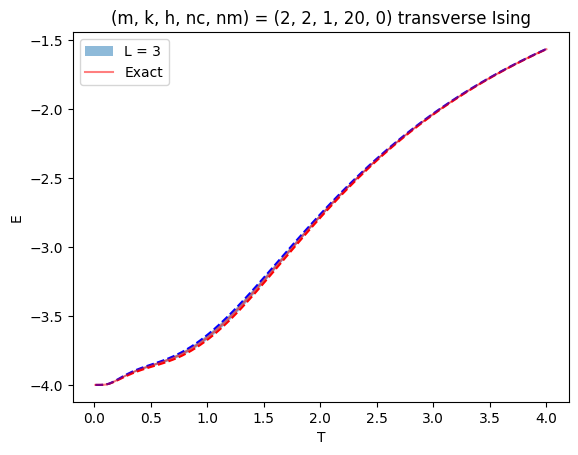

In [27]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, label=f'L = {L}')
plt.plot(1/betas, mins,c ='red',linestyle='--')
plt.plot(1/betas, maxs,c ='blue',linestyle='--')
plt.plot(Temp, Energy, alpha=0.5, label='Exact', c='red')
# plt.xlim(0.0,2.0)
# plt.ylim(-4.0,-2.5)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
plt.legend()
plt.show()

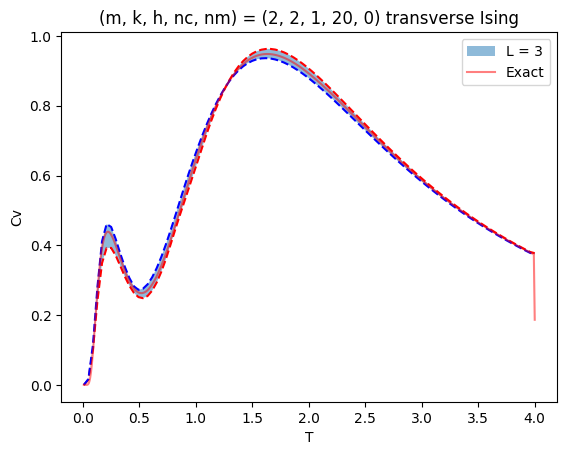

In [28]:
plt.fill_between(1/betas, np.gradient(mins, 1/betas), np.gradient(maxs, 1/betas), alpha = 0.5, label=f'L = {L}')
plt.plot(1/betas, np.gradient(mins, 1/betas),c ='red',linestyle='--')
plt.plot(1/betas, np.gradient(maxs, 1/betas),c ='blue',linestyle='--')
plt.plot(Temp, Cv, label='Exact', c='red', alpha=0.5)
plt.xlabel('T')
plt.ylabel('Cv')
plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
plt.legend()
plt.show()

In [29]:
# ZZmins = [V[SiteBasis(L).rank('ZZ')] for V in Bmins]
# ZZmaxs = [V[SiteBasis(L).rank('ZZ')] for V in Bmaxs]
# plt.fill_between(1/betas, ZZmins, ZZmaxs, alpha = 0.5, label=f'L = {L} ZZ')
# plt.plot(1/betas, ZZmins,c ='red',linestyle='--')
# plt.plot(1/betas, ZZmaxs,c ='blue',linestyle='--')
# XXmins = [V[SiteBasis(L).rank('XX')] for V in Bmins]
# XXmaxs = [V[SiteBasis(L).rank('XX')] for V in Bmaxs]
# plt.fill_between(1/betas, XXmins, XXmaxs, alpha = 0.5, label=f'L = {L} XX')
# plt.plot(1/betas, XXmins,c ='red',linestyle='--')
# plt.plot(1/betas, XXmaxs,c ='blue',linestyle='--')
# YYmins = [V[SiteBasis(L).rank('YY')] for V in Bmins]
# YYmaxs = [V[SiteBasis(L).rank('YY')] for V in Bmaxs]
# plt.fill_between(1/betas, YYmins, YYmaxs, alpha = 0.5, label=f'L = {L} YY')
# plt.plot(1/betas, YYmins,c ='red',linestyle='--')
# plt.plot(1/betas, YYmaxs,c ='blue',linestyle='--')
# # plt.plot(Temp, expZ, alpha=0.5, label='Exact', c='red')
# plt.xlabel('T')
# plt.ylabel('<ZZ>')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()

In [30]:
# Z0mins = [V[SiteBasis(L).rank('ZII')]+V[SiteBasis(L).rank('IZI')]+V[SiteBasis(L).rank('IIZ')] for V in Bmins]
# Z0maxs = [V[SiteBasis(L).rank('ZII')]+V[SiteBasis(L).rank('IZI')]+V[SiteBasis(L).rank('IIZ')] for V in Bmaxs]
# plt.fill_between(1/betas, Z0mins, Z0maxs, alpha = 0.5, label=f'L = {L}')
# plt.plot(1/betas, Z0mins,c ='red',linestyle='--')
# plt.plot(1/betas, Z0maxs,c ='blue',linestyle='--')
# plt.plot(Temp, expZ, alpha=0.5, label='Exact', c='red')
# plt.xlabel('T')
# plt.ylabel('<Z0>')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()

In [31]:
# XXmins = [V[SiteBasis(L).rank('XX')] for V in Bmins]
# XXmaxs = [V[SiteBasis(L).rank('XX')] for V in Bmaxs]
# plt.fill_between(1/betas, XXmins, XXmaxs, alpha = 0.5, label=f'L = {L}')
# plt.plot(1/betas, XXmins,c ='red',linestyle='--')
# plt.plot(1/betas, XXmaxs,c ='blue',linestyle='--')
# plt.plot(Temp, expXX, alpha=0.5, label='Exact', c='red')
# plt.xlabel('T')
# plt.ylabel('<XX>')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()